### 패키지 선언

In [1]:
import torch
use_cuda = torch.cuda.is_available()
print(use_cuda)
import torch.nn as nn
import torchvision.datasets as dataset
import torchvision.transforms as transform
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

True


## Dataset 다운로드

In [2]:
# Training dataset 다운로드
cifar100_train = dataset.CIFAR100(root = "./",
                            train = True,
                            transform = transform.ToTensor(),
                            download = True)
# Testing dataset 다운로드
cifar100_test = dataset.CIFAR100(root = "./",
                            train = False,
                            transform = transform.ToTensor(),
                            download = True)

dataLabel = [
    'beaver', 'dolphin', 'otter', 'seal', 'whale',
    'aquarium fish', 'flatfish', 'ray', 'shark', 'trout',
    'orchids', 'poppies', 'roses', 'sunflowers', 'tulips',
    'bottles', 'bowls', 'cans', 'cups', 'plates',
    'apples', 'mushrooms', 'oranges', 'pears', 'sweet peppers',
    'clock', 'computer keyboard', 'lamp', 'telephone', 'television',
    'bed', 'chair', 'couch', 'table', 'wardrobe',
    'bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach',
    'bear', 'leopard', 'lion', 'tiger', 'wolf',
    'bridge', 'castle', 'house', 'road', 'skyscraper',
    'cloud', 'forest', 'mountain', 'plain', 'sea',
    'camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo',
    'fox', 'porcupine', 'possum', 'raccoon', 'skunk',
    'crab', 'lobster', 'snail', 'spider', 'worm',
    'baby', 'boy', 'girl', 'man', 'woman',
    'crocodile', 'dinosaur', 'lizard', 'snake', 'turtle',
    'hamster', 'mouse', 'rabbit', 'shrew', 'squirrel',
    'maple', 'oak', 'palm', 'pine', 'willow',
    'bicycle', 'bus', 'motorcycle', 'pickup truck', 'train',
    'lawn-mower', 'rocket', 'streetcar', 'tank', 'tractor'
]


100%|██████████| 169001437/169001437 [00:03<00:00, 54081578.01it/s]


Extracting ./cifar-100-python.tar.gz to ./
Files already downloaded and verified


## 신경망 모델 정의
- Fully Connected Layer -> nn.Linear(in_features, out_features)
- Convolutional Layer -> nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
- ReLU -> nn.ReLU()
- Max Pooling -> nn.MaxPool2d(kernel_size, stride)


In [3]:
class Network(nn.Module):

  def __init__(self):
    super(Network, self).__init__()

    # 신경망 파라미터 초기화 (Conv 6개, FC 3개, ReLU, MaxPool)
    self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)    # Convolution: [3x3x3]x16, s1, p1
    self.conv1_2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)   # Convolution: [3x3x16]x32, s1, p1

    self.conv2_1 = nn.Conv2d(in_channels=35, out_channels=32, kernel_size=3, stride=1, padding=1)   # Convolution: [3x3x35]x32, s1, p1
    self.conv2_2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)   # Convolution: [3x3x32]x64, s1, p1

    self.conv3_1 = nn.Conv2d(in_channels=99, out_channels=128, kernel_size=3, stride=1, padding=1)  # Convolution: [3x3x99]x128, s1, p1
    self.conv3_2 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1) # Convolution: [3x3x128]x256, s1, p1

    self.fc1 = nn.Linear(in_features=4096, out_features=512)
    self.fc2 = nn.Linear(in_features=512, out_features=256)
    self.fc3 = nn.Linear(in_features=256, out_features=100)

    self.relu = nn.ReLU()
    self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

    #-----------------------------------------------------------------
    # Dropout layer 추가
    self.dropout = nn.Dropout(p=0.5)

    # Skip connection을 위한 convolution layer 추가
    self.conv_skip1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
    # Dense 적용해서 channel 수를 맞춤.
    self.conv_skip2 = nn.Conv2d(in_channels=35, out_channels=64, kernel_size=3, stride=1, padding=1)
    self.conv_skip3 = nn.Conv2d(in_channels=99, out_channels=256, kernel_size=3, stride=1, padding=1)
    # CA 추가
    self.channel_attention = ChannelAttention(channels=64,reduction=1)
  def forward(self, x):
    #-----------------------------------------------------------------
    # Convolution, ReLU, MaxPool layer
    skip_y = self.conv_skip1(x)
    dense_y = x
    y = self.relu(self.conv1_1(x))
    y = self.relu(self.conv1_2(y))
    y = y + skip_y # skip connection 적용
    y = torch.cat([y,dense_y],dim = 1) #Dense 적용
    y = self.max_pool(y)

    dense_y = y
    skip_y = self.conv_skip2(y)
    y = self.relu(self.conv2_1(y))
    y = self.relu(self.conv2_2(y))
    #-----------------------------------------------------------------
    # CA 추가
    y = self.channel_attention(y)
    y = y + skip_y # skip connection 적용
    y = torch.cat([y,dense_y],dim = 1) #Dense 적용
    y = self.max_pool(y)

    skip_y = self.conv_skip3(y)
    y = self.relu(self.conv3_1(y))
    y = self.relu(self.conv3_2(y))
    y = y + skip_y # skip connection 적용
    y = self.max_pool(y)

    #-----------------------------------------------------------------
    # Dropout 적용
    y = self.dropout(y)

    #-----------------------------------------------------------------

    y = y.view(-1, 4096) # feature map 평탄화

    #-----------------------------------------------------------------
    # Fully Connected, ReLU layer
    y = self.relu(self.fc1(y))
    y = self.relu(self.fc2(y))
    y = self.fc3(y)
    #-----------------------------------------------------------------

    return y


In [4]:
class ChannelAttention(nn.Module):
  def __init__(self,channels,reduction):
    super(ChannelAttention,self).__init__()
    self.gap = nn.AdaptiveAvgPool2d((1,1))
    self.conv1 = nn.Conv2d(in_channels=channels, out_channels=channels//reduction,kernel_size=1)
    self.conv2 = nn.Conv2d(in_channels=channels//reduction, out_channels=channels,kernel_size=1)
    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()

  def forward(self,x):
    ca_out = self.gap(x)
    ca_out = self.relu(self.conv1(ca_out))
    ca_out = self.sigmoid(self.conv2(ca_out))
    ca_out = ca_out.expand_as(x)
    y = x * ca_out

    return y

## Hyper-parameters 지정

In [5]:
batch_size = 100      # 고정 하이퍼 파라미터
training_epochs = 30  # 고정 하이퍼 파라미터

learning_rate = 0.1
loss_function = nn.CrossEntropyLoss()
network = Network().to('cuda')
optimizer = torch.optim.SGD(network.parameters(), lr = learning_rate)

# ---------------------------------------------------------
# Learning rate scheduler 추가
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1  )

data_loader = DataLoader(dataset=cifar100_train,
                         batch_size=batch_size,
                         shuffle=True,
                         drop_last=True)

## CNN 학습을 위한 반복문 선언

In [6]:
for epoch in range(training_epochs):
  network.train()
  avg_cost = 0
  total_batch = len(data_loader)

  for img, label in data_loader:
    img = img.to('cuda')
    label = label.to('cuda')
    pred = network(img)

    loss = loss_function(pred, label)
    optimizer.zero_grad() # gradient 초기화
    loss.backward()
    optimizer.step()

    avg_cost += loss / total_batch
  # -----------------------------------------------
  # Learning rate 갱신
  scheduler.step()


  print('Epoch: %d Loss = %f'%(epoch+1, avg_cost))

print('Learning finished')

Epoch: 1 Loss = 4.390591
Epoch: 2 Loss = 3.698657
Epoch: 3 Loss = 3.281629
Epoch: 4 Loss = 2.994432
Epoch: 5 Loss = 2.746370
Epoch: 6 Loss = 2.516502
Epoch: 7 Loss = 2.305045
Epoch: 8 Loss = 2.118453
Epoch: 9 Loss = 1.944157
Epoch: 10 Loss = 1.777537
Epoch: 11 Loss = 1.299153
Epoch: 12 Loss = 1.197109
Epoch: 13 Loss = 1.132789
Epoch: 14 Loss = 1.085127
Epoch: 15 Loss = 1.038337
Epoch: 16 Loss = 0.997502
Epoch: 17 Loss = 0.964349
Epoch: 18 Loss = 0.918045
Epoch: 19 Loss = 0.882297
Epoch: 20 Loss = 0.843446
Epoch: 21 Loss = 0.767947
Epoch: 22 Loss = 0.755176
Epoch: 23 Loss = 0.747961
Epoch: 24 Loss = 0.744870
Epoch: 25 Loss = 0.740507
Epoch: 26 Loss = 0.735899
Epoch: 27 Loss = 0.730747
Epoch: 28 Loss = 0.727008
Epoch: 29 Loss = 0.716517
Epoch: 30 Loss = 0.718444
Learning finished


## 학습이 완료된 모델을 이용해 정답률 확인

In [7]:
network.eval()
network = network.to('cpu')
img_test = torch.tensor(np.transpose(cifar100_test.data,(0,3,1,2))) / 255.
label_test = torch.tensor(cifar100_test.targets)

with torch.no_grad(): # test에서는 기울기 계산 제외
  prediction = network(img_test) # 전체 test data를 한번에 계산

  correct_prediction = torch.argmax(prediction, 1) == label_test
  accuracy = correct_prediction.float().mean()
  print('Accuracy:', accuracy.item())

Accuracy: 0.48240000009536743


예측결과 확인

tensor([[ 1.7992, -1.0848, -1.1496,  0.0574, -1.1345, -4.4634,  3.9022,  5.3723,
          0.6830,  5.1543,  1.8862,  0.7108, -1.2942,  0.7314,  5.6773, -0.1286,
          4.4958, -2.2699,  2.8642,  0.9289, -0.5460, -4.2043,  0.3344, -1.9167,
          0.4925,  1.1888,  1.8646, -2.5722,  1.1773, -0.5368, -3.1059, -3.0637,
         -0.6699,  2.0197, -0.8229, -1.1598, -0.4649, -1.6807,  1.1126,  0.9457,
          2.6416,  1.5295, -1.9976,  1.2067,  2.8220,  3.1881, -0.4871,  0.2625,
          2.8963, -3.6662, -0.9838, -1.3387, -4.4609,  0.1874,  5.7568, -0.5945,
         -4.0626,  4.1820, -4.5094, -0.6458, -4.0588, -2.0706,  7.7697, -5.6483,
         -1.0764, -0.7984, -0.8414, -4.7511, -4.7565, -0.1250,  5.4601, -2.6219,
         -3.7772, -3.6530,  0.5207, -1.2854, -2.6437, -0.8224,  0.8379,  3.1705,
         -2.3050, -4.9301,  6.2118,  5.4491,  2.7128, -8.1848,  1.4793, -1.0193,
         -0.3662, -0.6521,  0.2145, -2.0211,  9.2562, -3.6700, -0.8880, -4.9128,
         -2.1279, -2.8241, -

<function matplotlib.pyplot.show(close=None, block=None)>

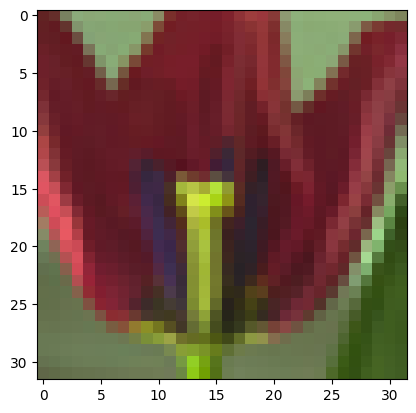

In [8]:
dataIdx = 2000
tmp_img = img_test[dataIdx].unsqueeze(0)
tmp_label = label_test[dataIdx]

with torch.no_grad():
  prediction = network(tmp_img)
tmp_img = tmp_img.squeeze(0)

prediction_num = torch.argmax(prediction, 1)

print(prediction)
print("prediction: ", dataLabel[prediction_num])
print("label: ", dataLabel[tmp_label])

plt.imshow(np.transpose(tmp_img.to('cpu'),(1,2,0)))
plt.show